In [197]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

    

In [7]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.feature import hog
import os
import pickle
import glob2
import time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline


import warnings
warnings.filterwarnings('ignore')

In [8]:
### TODO: Tweak these parameters and see how the results change.
color_space = 'HSV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (14, 14) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()


scaler = MinMaxScaler(feature_range=(0, 1), copy=True)

In [9]:
def newSpace(image):
    R = scaler.fit_transform(image[:, :, 0])
    #B = scaler.fit_transform(image[:, :, 2])
    Y = scaler.fit_transform(cspace(image, color_space='YCrCb')[:, :, 0])
    L = scaler.fit_transform(cspace(image, color_space='HLS')[:, :, 0])
    return np.dstack((R, Y, L))
    
    
def cspace(image, color_space='RGB'):
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)    
    return feature_image

In [150]:
    
def single_extract(image, cspace="YCrCb", 
                   orient=9, pix_per_cell=8, cell_per_block=2, feature_vec=True):
    # Create a list to append feature vectors to
        features = []

        # Iterate through the list of images
        # Read in each one by one
        # apply color conversion if other than 'RGB'
        
        image = cv2.resize(image, (64, 64))
        
        feature_image = newSpace(image)
        # Call get_hog_features() with vis=False, feature_vec=True
        #hog_features = []
        #for channel in range(feature_image.shape[2]):
            #hog_features.append(get_hog_features(feature_image[:,:,channel], 
             #                   orient, pix_per_cell, cell_per_block, 
              #                  vis=False, feature_vec=feature_vec))
            
        hog_features = get_hog_features(feature_image[:,:,1], 
                                orient, pix_per_cell, cell_per_block, 
                                vis=False, feature_vec=feature_vec)
        hog_features = np.ravel(hog_features)        

        hog_features = hog_features.reshape(1, -1)

        #Combine in order of hist, bin and hog
        
        return hog_features
        

In [11]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    result = np.copy(img)
    
    for i in range(len(bboxes)):
        cv2.rectangle(result,bboxes[i][0],bboxes[i][1],(0,255,0), 2) 
        
    return result

(64, 64, 3)

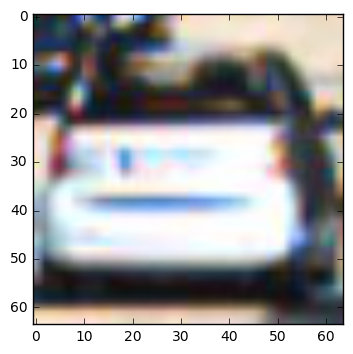

In [9]:
image = mpimg.imread('vehicles_smallset/cars1/62.jpeg')
plt.imshow(image)
image.shape

In [8]:
temp = single_extract(image)
temp.shape

(1, 5292)

In [12]:
import sys
sys.path.append("C:/xgboost/python-package")
import xgboost as xgb


bst = xgb.Booster(model_file='xgb.model')

In [405]:
bstfull = xgb.Booster(model_file='xgbfull.model')
bstfcrb = xgb.Booster(model_file='xgbcrb.model')


In [13]:
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.7, 0.7)):
    
    # If x and/or y start/stop positions not defined, set to image size
        if x_start_stop[0] == None:
            x_start_stop[0] = 0
        if x_start_stop[1] == None:
            x_start_stop[1] = img.shape[1]
        if y_start_stop[0] == None:
            y_start_stop[0] = 0
        if y_start_stop[1] == None:
            y_start_stop[1] = img.shape[0]
        # Compute the span of the region to be searched    
        xspan = x_start_stop[1] - x_start_stop[0]
        yspan = y_start_stop[1] - y_start_stop[0]
        # Compute the number of pixels per step in x/y
        nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
        ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
        # Compute the number of windows in x/y
        nx_windows = np.int(xspan/nx_pix_per_step) - 1
        ny_windows = np.int(yspan/ny_pix_per_step) - 1
        # Initialize a list to append window positions to
        window_list = []
        # Loop through finding x and y window positions
        # Note: you could vectorize this step, but in practice
        # you'll be considering windows one by one with your
        # classifier, so looping makes sense
        for ys in range(ny_windows):
            for xs in range(nx_windows):
                # Calculate window position
                startx = xs*nx_pix_per_step + x_start_stop[0]
                endx = startx + xy_window[0]
                starty = ys*ny_pix_per_step + y_start_stop[0]
                endy = starty + xy_window[1]

                # Append window position to list
                window_list.append(((startx, starty), (endx, endy)))
        # Return the list of windows
        return window_list



In [203]:
def search_windows(img, windows, clf, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))   
        
        
        
        #4) Extract features for that window using single_img_features()
        features = single_extract(test_img)
        #5) Scale extracted features to be fed to classifier
        #test_features = scaler.transform(np.array(features).reshape(1, -1))
        #test_features = np.array(features).reshape(1, -1)
        #6) Predict using your classifier
        prediction = clf.predict(xgb.DMatrix(features))
        #7) If positive (prediction == 1) then save the window
        
        ## For xgboost, using 0.4 as threshold
        prediction = (prediction > 0.9) * 1
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [15]:
64*10

640

In [227]:
image = mpimg.imread('test_images/test2.jpg')
#image = mpimg.imread('image.jpg')

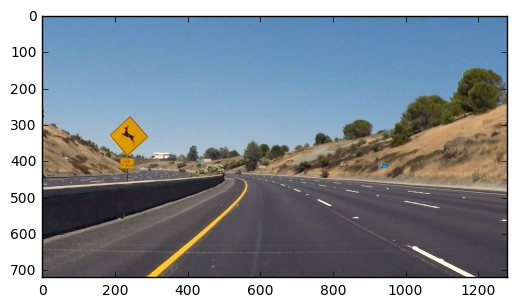

In [228]:
windows = slide_window(image, x_start_stop=[800, None], xy_window=(120, 120), y_start_stop=[400, 656], xy_overlap=(0.7, 0.7))
#windows2 = slide_window(image, x_start_stop=[64*11, None], xy_window=(80, 80), y_start_stop=[int(image.shape[0]/2), int(image.shape[0])], xy_overlap=(0.9, 0.9))
#windows3 = slide_window(image, x_start_stop=[800, None], xy_window=(96, 96), y_start_stop=[400, 656], xy_overlap=(0.8, 0.8))

#windows.extend(windows2)
#windows.extend(windows3)

hot_windows = search_windows(image, windows, bst, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)


In [212]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap


def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

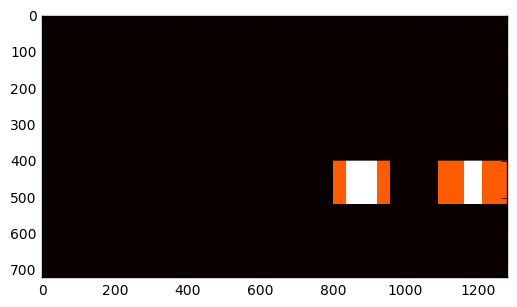

In [219]:
# Read in the last image shown above 
heat = np.zeros_like(image[:,:,0]).astype(np.float)

temp = add_heat(heat, hot_windows)
tempi = apply_threshold(temp, 0)
plt.imshow(tempi, cmap="hot")

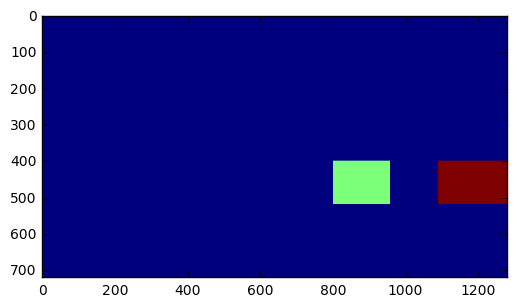

In [220]:
from scipy.ndimage.measurements import label
labels = label(tempi)

plt.imshow(labels[0], cmap='jet')

In [221]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (60,15,180), 6)
    # Return the image
    return img


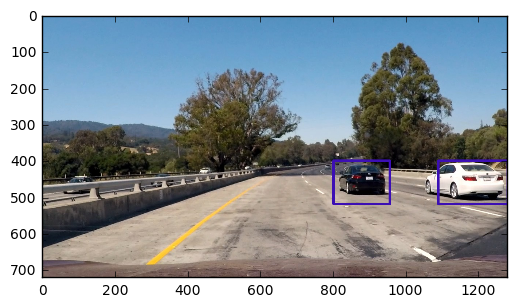

In [222]:
plt.imshow(draw_labeled_bboxes(np.copy(image), labels))

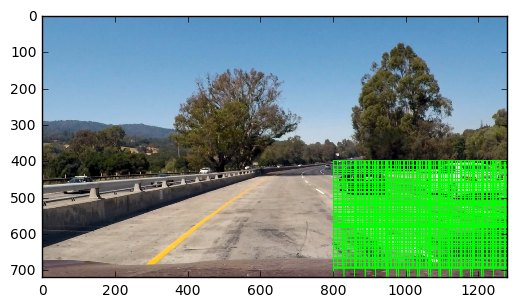

In [201]:
plt.imshow(draw_boxes(image, windows, color=(0, 0, 255), thick=6))

In [20]:
def pipeline(image):
    windows = slide_window(image, x_start_stop=[64*11, None], xy_window=(128, 128), y_start_stop=[64*5, 700], xy_overlap=(0.9, 0.9))
    windows3 = slide_window(image, x_start_stop=[64*11, None], xy_window=(64, 64), y_start_stop=[64*5, 700], xy_overlap=(0.9, 0.9))

    windows.extend(windows3)

    hot_windows = search_windows(image, windows, bst, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat) 
    
    
    temp.append(hot_windows)

    #window_img = draw_boxes(image, hot_windows, color=(0, 0, 255), thick=6)  
    
    return window_img

In [21]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
white_output = 'temp.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

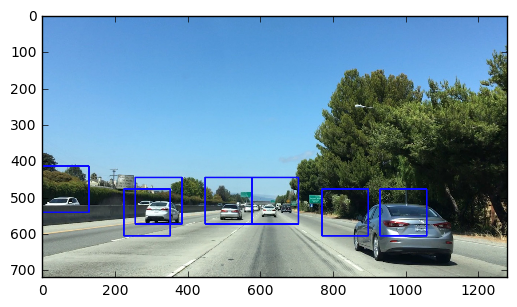

In [94]:
plt.imshow(draw_img)

In [297]:
temp=[]

In [298]:
def search_windows_hog(image, scale=[1, 2, 3]):
    ystart = 400
    ystop = 656
    
    xstart = 800
    xstop = 1280
    #scale = 2

    img_boxes = []
    count = 0
    draw_img = np.copy(image)

    img = newSpace(image)
    heatmap = np.zeros_like(img[:, :, 0])


    ctrans_tosearch = img[ystart:ystop, xstart:, :]
    
    for each in scale:

        if each != 1:
            imshape = ctrans_tosearch.shape
            ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/each), np.int(imshape[0]/each)))

        #ch1 = ctrans_tosearch[:, :, 0] 
        ch2 = ctrans_tosearch[:, :, 1] 
        #ch3 = ctrans_tosearch[:, :, 2] 


        #define blocks and steps as above

        nxblocks = (ch2.shape[1] // pix_per_cell) - 1
        nyblocks = (ch2.shape[0] // pix_per_cell) - 1
        nfeat_per_block = orient*cell_per_block**2
        window = 64
        nblocks_per_window = (window // pix_per_cell) - 1
        cells_per_step = 2
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step

        #hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        #hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
        
        
        for xb in range(nxsteps):
            for yb in range(nysteps):
                count += 1
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step

                #hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                #hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                #hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
                #hog_features = hog_feat2

                xleft = xpos*pix_per_cell
                ytop = ypos*pix_per_cell

                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64, 64))


                prediction = bst.predict(xgb.DMatrix(hog_feat2.reshape(1, -1)))
                prediction = (prediction > 0.8) * 1

                if prediction == 1:
                    xbox_left = np.int(xleft*each) + xstart
                    ytop_draw = np.int(ytop*each)
                    win_draw = np.int(window*each)
                    #cv2.rectangle(draw_img, (xbox_left, ytop_draw+ystart), (xbox_left+win_draw, ytop_draw+win_draw+ystart), (10, 10, 50), 3)

                    img_boxes.append(((xbox_left, ytop_draw+ystart), (xbox_left+win_draw, ytop_draw+win_draw+ystart)))
                    heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left:xbox_left+win_draw] += 1
                    
        temp.append(heatmap)
                    
                
    return heatmap


In [293]:
def processHeat(inp, image, threshold=15):
    heatThresh = apply_threshold(inp, threshold)
    labels = label(heatThresh)
    return draw_labeled_bboxes(np.copy(image), labels)
    

In [294]:
def newPipeline(image):
    heatImage = search_windows_hog(image, scale=[1, 1.6])
    
    #result = processHeat(heatImage, image)
    if len(temp) > 1:
        hold = np.sum(np.array(temp[-5:]), axis=0)
    else:
        hold = heatImage
        
    result = processHeat(hold, image)
    
    return result

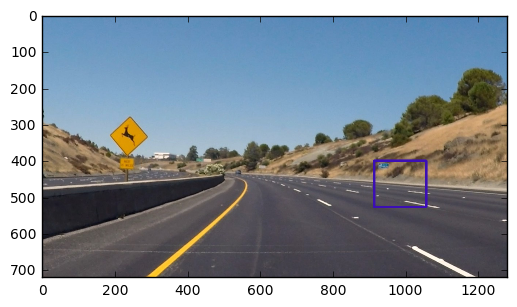

In [243]:
#temp = Heat()
result = newPipeline(image)
plt.imshow(result)

In [299]:
white_output = 'temp.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(newPipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video temp.mp4
[MoviePy] Writing video temp.mp4


100%|█████████████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [15:43<00:00,  1.16it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: temp.mp4 

Wall time: 15min 45s


In [300]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [22]:
class Heat():
    def __init__(self):
        # was the line detected in the last iteration?
        self.box = []  
        self.currentBox = None